## Bayesian Neural Networks in Keras and TensorFlow 2.0

In [22]:
#! . activate base
#!pip install tensorflow==2.0.0b1 --user
#!pip install tfp_nightly --user
#!python -m ipykernel install --name tf_prob --user

In [23]:
#TODO: PUT RANDOM SEED FOR RESULT SECURING IN DEMOS
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

%matplotlib inline

In [24]:
print('TensorFlow version (expected = 2.0.0-beta1):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0-beta1): 2.0.0-beta1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.9.0-dev20190913


In [25]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## We are all set up, lets go!

We are using CIFAR10 dataset!
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 10)


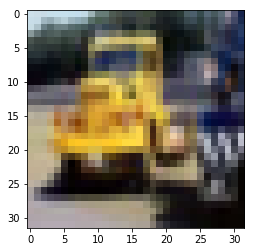

In [26]:
"""
first, we load the dataset. We are trying to do it first with CIFAR
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using CIFAR10 dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
#X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, :])

In [27]:
def build_bayesian_bcnn_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)

    
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_3(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    dense_1 = tfp.python.layers.DenseFlipout(256, activation='relu')
    x = dense_1(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    dense_2 = tfp.python.layers.DenseFlipout(256, activation='relu')
    x = dense_2(x)
    
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    dense_3 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_3(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

In [28]:
"""
here we are just instancing our model and setting up an Optimizer
"""
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [29]:
bcnn.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_flipout_7 (Conv2DFlip (None, 16, 16, 32)        1760      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_flipout_8 (Conv2DFlip (None, 3, 3, 64)          36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 3, 64)          256 

In [19]:
"""
this is our loss function: a sum of KL Divergence and Softmax crossentropy
We use the @tf.function annotation becuase of TF2.0, and need no placeholders
we get each loss and return its mean
"""

@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [20]:
"""
this is our train step with tf2.0, very ellegant:
We do our flow of the tensors over the model recording its gradientes
Then, our gradient tape to give us a list of the gradients of each parameter in relation of the loss
we dan ask our previously instanced optimizer to apply those gradients to the variable
It is cool to see that it works even with TensorFlow probability- probabilistic layers parameters
"""
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

In [21]:
"""
in our train step we can see that it lasts more tha na normal CNN to converge
on the other side, we can have the confidence interval for our predictions, which are 
wonderful in terms of taking sensitive predictions
"""
times = []
for i in range(700):
    tic = time.time()
    loss = train_step(X_train, y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, y_train)
    preds_test = bcnn(X_test)
    test_acc = accuracy(preds_test, y_test)
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, test_acc = {:7.3f} time: {:7.3f}".format(i, loss, acc, test_acc, train_time))

Epoch: 0: loss =   9.104 , accuracy =   0.100, test_acc =   0.101 time:  44.111
Epoch: 1: loss =  13.590 , accuracy =   0.102, test_acc =   0.101 time:   8.370
Epoch: 2: loss =  10.281 , accuracy =   0.103, test_acc =   0.097 time:   8.344
Epoch: 3: loss =   7.812 , accuracy =   0.099, test_acc =   0.094 time:   8.363
Epoch: 4: loss =   5.133 , accuracy =   0.100, test_acc =   0.097 time:   8.421
Epoch: 5: loss =   3.610 , accuracy =   0.102, test_acc =   0.099 time:   8.312
Epoch: 6: loss =   3.008 , accuracy =   0.099, test_acc =   0.102 time:   8.321
Epoch: 7: loss =   2.826 , accuracy =   0.101, test_acc =   0.096 time:   8.395
Epoch: 8: loss =   2.778 , accuracy =   0.099, test_acc =   0.101 time:   8.476
Epoch: 9: loss =   2.694 , accuracy =   0.099, test_acc =   0.099 time:   8.352
Epoch: 10: loss =   2.623 , accuracy =   0.099, test_acc =   0.097 time:   8.423
Epoch: 11: loss =   2.570 , accuracy =   0.102, test_acc =   0.103 time:   8.344
Epoch: 12: loss =   2.509 , accuracy =

Epoch: 102: loss =   2.038 , accuracy =   0.229, test_acc =   0.241 time:   8.321
Epoch: 103: loss =   2.029 , accuracy =   0.240, test_acc =   0.233 time:   8.321
Epoch: 104: loss =   2.057 , accuracy =   0.232, test_acc =   0.243 time:   8.408
Epoch: 105: loss =   2.019 , accuracy =   0.241, test_acc =   0.243 time:   8.431
Epoch: 106: loss =   2.020 , accuracy =   0.232, test_acc =   0.245 time:   8.309
Epoch: 107: loss =   2.022 , accuracy =   0.246, test_acc =   0.236 time:   8.337
Epoch: 108: loss =   2.025 , accuracy =   0.245, test_acc =   0.246 time:   8.350
Epoch: 109: loss =   1.999 , accuracy =   0.234, test_acc =   0.247 time:   8.318
Epoch: 110: loss =   2.002 , accuracy =   0.246, test_acc =   0.241 time:   8.411
Epoch: 111: loss =   2.003 , accuracy =   0.250, test_acc =   0.238 time:   8.377
Epoch: 112: loss =   2.010 , accuracy =   0.240, test_acc =   0.253 time:   8.410
Epoch: 113: loss =   2.012 , accuracy =   0.247, test_acc =   0.244 time:   8.367
Epoch: 114: loss

Epoch: 202: loss =   1.659 , accuracy =   0.392, test_acc =   0.395 time:   8.398
Epoch: 203: loss =   1.682 , accuracy =   0.397, test_acc =   0.395 time:   8.383
Epoch: 204: loss =   1.675 , accuracy =   0.388, test_acc =   0.401 time:   8.452
Epoch: 205: loss =   1.663 , accuracy =   0.397, test_acc =   0.400 time:   8.462
Epoch: 206: loss =   1.664 , accuracy =   0.393, test_acc =   0.399 time:   8.422
Epoch: 207: loss =   1.650 , accuracy =   0.398, test_acc =   0.403 time:   8.361
Epoch: 208: loss =   1.638 , accuracy =   0.405, test_acc =   0.389 time:   8.396
Epoch: 209: loss =   1.644 , accuracy =   0.403, test_acc =   0.402 time:   8.391
Epoch: 210: loss =   1.633 , accuracy =   0.401, test_acc =   0.409 time:   8.418
Epoch: 211: loss =   1.643 , accuracy =   0.403, test_acc =   0.404 time:   8.417
Epoch: 212: loss =   1.635 , accuracy =   0.407, test_acc =   0.415 time:   8.440
Epoch: 213: loss =   1.628 , accuracy =   0.408, test_acc =   0.400 time:   8.449
Epoch: 214: loss

Epoch: 302: loss =   1.435 , accuracy =   0.483, test_acc =   0.467 time:   8.592
Epoch: 303: loss =   1.431 , accuracy =   0.483, test_acc =   0.463 time:   8.527
Epoch: 304: loss =   1.432 , accuracy =   0.483, test_acc =   0.467 time:   8.418
Epoch: 305: loss =   1.430 , accuracy =   0.484, test_acc =   0.475 time:   8.421
Epoch: 306: loss =   1.422 , accuracy =   0.485, test_acc =   0.475 time:   8.484
Epoch: 307: loss =   1.443 , accuracy =   0.482, test_acc =   0.473 time:   8.522
Epoch: 308: loss =   1.434 , accuracy =   0.486, test_acc =   0.474 time:   8.604
Epoch: 309: loss =   1.429 , accuracy =   0.486, test_acc =   0.465 time:   8.429
Epoch: 310: loss =   1.415 , accuracy =   0.487, test_acc =   0.471 time:   8.430
Epoch: 311: loss =   1.434 , accuracy =   0.483, test_acc =   0.469 time:   8.438
Epoch: 312: loss =   1.435 , accuracy =   0.488, test_acc =   0.476 time:   8.434
Epoch: 313: loss =   1.420 , accuracy =   0.486, test_acc =   0.465 time:   8.525
Epoch: 314: loss

Epoch: 402: loss =   1.294 , accuracy =   0.533, test_acc =   0.502 time:   8.452
Epoch: 403: loss =   1.316 , accuracy =   0.534, test_acc =   0.506 time:   8.499
Epoch: 404: loss =   1.292 , accuracy =   0.534, test_acc =   0.497 time:   8.486
Epoch: 405: loss =   1.303 , accuracy =   0.533, test_acc =   0.506 time:   8.560
Epoch: 406: loss =   1.293 , accuracy =   0.534, test_acc =   0.503 time:   8.478
Epoch: 407: loss =   1.289 , accuracy =   0.536, test_acc =   0.495 time:   8.594
Epoch: 408: loss =   1.293 , accuracy =   0.530, test_acc =   0.505 time:   8.533
Epoch: 409: loss =   1.294 , accuracy =   0.530, test_acc =   0.501 time:   8.586
Epoch: 410: loss =   1.284 , accuracy =   0.532, test_acc =   0.502 time:   8.597
Epoch: 411: loss =   1.299 , accuracy =   0.536, test_acc =   0.503 time:   8.481
Epoch: 412: loss =   1.296 , accuracy =   0.536, test_acc =   0.498 time:   8.563
Epoch: 413: loss =   1.290 , accuracy =   0.532, test_acc =   0.503 time:   8.475
Epoch: 414: loss

Epoch: 502: loss =   1.176 , accuracy =   0.576, test_acc =   0.513 time:   8.647
Epoch: 503: loss =   1.177 , accuracy =   0.578, test_acc =   0.509 time:   8.655
Epoch: 504: loss =   1.180 , accuracy =   0.576, test_acc =   0.515 time:   8.607
Epoch: 505: loss =   1.179 , accuracy =   0.578, test_acc =   0.517 time:   8.721
Epoch: 506: loss =   1.177 , accuracy =   0.578, test_acc =   0.514 time:   8.594
Epoch: 507: loss =   1.180 , accuracy =   0.577, test_acc =   0.508 time:   8.728
Epoch: 508: loss =   1.177 , accuracy =   0.581, test_acc =   0.519 time:   8.663
Epoch: 509: loss =   1.163 , accuracy =   0.577, test_acc =   0.519 time:   8.750
Epoch: 510: loss =   1.160 , accuracy =   0.581, test_acc =   0.514 time:   8.652
Epoch: 511: loss =   1.175 , accuracy =   0.581, test_acc =   0.510 time:   8.723
Epoch: 512: loss =   1.157 , accuracy =   0.582, test_acc =   0.516 time:   8.783
Epoch: 513: loss =   1.165 , accuracy =   0.580, test_acc =   0.510 time:   8.651
Epoch: 514: loss

Epoch: 602: loss =   1.050 , accuracy =   0.622, test_acc =   0.509 time:   8.686
Epoch: 603: loss =   1.049 , accuracy =   0.623, test_acc =   0.512 time:   8.770
Epoch: 604: loss =   1.045 , accuracy =   0.625, test_acc =   0.511 time:   8.654
Epoch: 605: loss =   1.027 , accuracy =   0.630, test_acc =   0.510 time:   8.666
Epoch: 606: loss =   1.031 , accuracy =   0.627, test_acc =   0.508 time:   8.729
Epoch: 607: loss =   1.042 , accuracy =   0.629, test_acc =   0.510 time:   8.617
Epoch: 608: loss =   1.034 , accuracy =   0.629, test_acc =   0.508 time:   8.661
Epoch: 609: loss =   1.035 , accuracy =   0.627, test_acc =   0.508 time:   8.690
Epoch: 610: loss =   1.027 , accuracy =   0.627, test_acc =   0.501 time:   8.674
Epoch: 611: loss =   1.035 , accuracy =   0.625, test_acc =   0.507 time:   8.690
Epoch: 612: loss =   1.046 , accuracy =   0.627, test_acc =   0.504 time:   8.603
Epoch: 613: loss =   1.031 , accuracy =   0.628, test_acc =   0.502 time:   8.700
Epoch: 614: loss

In [21]:
#bcnn.save_weights("bcnn_cifar10.h5")


In [ ]:
### About the performance:

mean = np.mean(times)
std = np.std(times)
print("In TensorFlow 2.0.0b1 our train time mean was : {:7.3f}, with std : {:7.3f}".format(mean, std))

no_outlier = times[1:]
no_mean = np.mean(no_outlier)
no_std = np.std(no_outlier)
print("\nHowever, by removing the outlier 1st time, our train time mean was : {:7.3f}, with std : {:7.3f}".format(no_mean, no_std))
#print("\nWe conclude TensorFlow 2 has a longer time to start its variables, but then does it faster than TF1.14 Intel Optimzied (see other notebook)")

### Now we will illustrate our predictions and confidence intervals

Those illustrative functions were taken from https://github.com/zhulingchen/tfp-tutorial/ repo, which had the tutorial (in Keras) that did let me learn how to 

### Here we have some statistics on recognizable and unrecognizable images from MNIST:

In [ ]:
n_mc_run = 100
med_prob_thres = 0.20

y_pred_logits_list = [bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

### With this other snippet, we can plot the predict distribution of our network:

In [ ]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

### This example is not recognizable:

In [ ]:
for idx in np.where(idx_invalid)[0]:
    plt.imshow(X_test[idx, :, :, :], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

    plot_pred_hist(y_pred_prob_all[idx], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

    if any(y_pred[idx]):
        print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
    else:
        print("I don't know!")

### A recognizable one:

In [ ]:
plt.imshow(X_test[0, :, :, :], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(y_test[0], axis=-1)))

plot_pred_hist(y_pred_prob_all[0], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[0]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[0], axis=-1)))
else:
    print("I don't know!")